# Домашнее задание №4

## Reviews Scraping

Стягиваем комментарии с фрагрантики в несколько шагов: 
1. По всем странам собираем ссылки на бренды
2. По брендам собираем данные об ароматах и о количестве комментариев к каждому из них
3. Собираем комментарии, начиная с самых популярных ароматов

In [121]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
import time
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import random
import os
import pandas as pd
import datetime
import re

options = Options()
options.add_argument("--headless") #по ощущениям лимит по запросам достигается быстрее с в хэдлесс
options.add_argument("--disable-gpu")
options.add_argument("--window-size=1920,1080")
options.add_argument("--no-sandbox")
options.add_argument("start-maximized")
options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                     "AppleWebKit/537.36 (KHTML, like Gecko) "
                     "Chrome/122.0.0.0 Safari/537.36")

Страны, в которых много брендов, выделяем в отдельный список, чтобы на них подольше подождать прогрузку страницы

In [2]:
big_countries = [ 'Australia', 'Brazil', 'Canada', 'France', 'Germany', 'Greece', 'Italy', 'Japan', 'Netherlands', 
                 'Oman', 'Poland', 'Russia', 'Saudi+Arabia', 'Spain', 'Sweden', 'Switzerland', 'Thailand',  
                 'Turkey', 'United+Arab+Emirates', 'United+Kingdom', 'United+States']

countries = ['Algeria', 'Argentina', 'Armenia', 'Aruba', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh',
             'Barbados', 'Belarus', 'Belgium', 'Belorussia', 'Bermuda', 'Bulgaria', 'Cabo+Verde',
             'Cayman+Islands', 'Chile', 'China', 'Colombia', 'Cote+D’Ivoire', 'Croatia', 'Cuba', 'Cyprus',
             'Czech+Republic', 'Denmark', 'Dominican+Republic', 'Dubai', 'Ecuador', 'Egypt', 'Estonia',
             'Finland', 'Georgia', 'Ghana', 'Guatemala', 'Hong+Kong', 'Hungary', 'Iceland', 'India',
             'Indonesia', 'Iran', 'Ireland', 'Israel', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia',
             'Lebanon', 'Liberia', 'Lithuania', 'Luxembourg', 'Malaysia', 'Malta', 'Mexico', 'Moldavia',
             'Monaco', 'Morocco', 'Myanmar', 'New+Zealand', 'Nigeria', 'Norway', 'Pakistan', 'Peru',
             'Philippines', 'Portugal', 'Puerto+Rico', 'Qatar', 'Romania', 'Rwanda', 'Serbia', 'Seychelles',
             'Singapore', 'Slovakia', 'South+Africa', 'South+Korea', 'Sri+Lanka', 'St.+Barts', 'Tahiti',
             'Taiwan', 'Ukraine', 'Uzbekistan', 'Vietnam', 'Wales', 'Zambia']

In [3]:
brand_urls = []

f = open('countries_brands_all.txt', 'r')
brand_urls = [x.strip() for x in f]
f.close()

In [ ]:
for country in countries:
    url = f'https://www.fragrantica.ru/country/{country}.html'
    print(url)
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    driver.get(url)
    
    if country in big_countries:
        time.sleep(7)
    else:
        time.sleep(3)
        
    brand_cells = driver.find_elements(By.CLASS_NAME, 'designerlist')
    
    brands = []
    for cell in brand_cells:
        brands += cell.find_elements(By.XPATH, ".//a")
        
    brand_list = [brand.get_attribute("href") for brand in brands]
    brand_urls += brand_list
    
    driver.close()

In [ ]:
f.open('countries_brands_all.txt', 'w')
for brand_url in brand_urls:
    f.write(brand_url+'\n')
f.close()

### Собираем информацию о ссылках на ароматы и количеству комментариев

После определённого количества запросов аккаунт доступ могут приостановить аж на несколько дней, поэтому подключаем к делу впн.

In [ ]:
os.mkdir('dumps')

In [5]:
class Perfumebox:
    def __init__(self, link, n):
        self.link = link
        self.n = n

In [6]:
def dump_to_csv(temp_data, filename):
    print(datetime.datetime.now())
    temp_df = pd.DataFrame([t.__dict__ for t in temp_data ])
    temp_df.to_csv(filename, mode = 'a', header = False, index = False)
    return []    

def scroll(driver, n_scrolls = 10):
    scroll_height = driver.execute_script("return window.screen.height;")      
    for x in range(n_scrolls):
        driver.execute_script(f"window.scrollBy(0, {scroll_height*0.7});")
        time.sleep(3)
    time.sleep(5)


#windows only!!    
def change_country(k, options):
    if k == 4:
        k = 0
    else:
        k += 1
    
    current = os.getcwd()
    os.chdir("C:\\Program Files\\NordVPN")
    os.system('nordvpn --disconnect')
    os.system(f"nordvpn -c -n 'Georgia #{options[k]}'")     
    os.chdir(current)
    
    time.sleep(60)
    return k

def start_driver(url, n_scrolls=10):
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    driver.get(url)
    scroll(driver, n_scrolls)
    return driver

def parse_perfumebox(perfume):
    comments = perfume.find_elements(By.CLASS_NAME, 'flex-child-shrink')
    name = perfume.find_elements(By.XPATH, ".//a")
    name = [x.get_attribute("href") for x in name]

    if len(name) > 0:
        name = name[0]
        if len(comments) > 0:
            if len(comments[2].text) == 0:
                num = 0
            else:
                try:
                    num = int(comments[2].text)
                except:
                    num = -1
        else: 
            num = -1
        return Perfumebox(name, num)
    else:
        return False

In [7]:
vpn_choice = [13, 14, 16, 20, 22]

In [8]:
i = 0
frags = []
current_country = 0

In [ ]:
temp = []

#uncomment for windows witn nordvpn installed
#current_country = change_country(current_country, vpn_choice)

for url in brand_urls[i:]:

    if i%20 == 0:
        print(i, 'process out of', len(brand_urls), url)
        temp = dump_to_csv(temp, filename = 'dumps/links_with_comment_number_dump.csv')

    try:
        driver = start_driver(url)
        
        perfumes = driver.find_elements(By.CLASS_NAME, 'prefumeHbox')

        if len(perfumes) == 0:
            driver.close()
            
            temp = dump_to_csv(temp, filename = 'dumps/links_with_comment_number_dump.csv')
            #uncomment for windows witn nordvpn installed to change vpn automatically
            #current_country = change_country(current_country, vpn_choice)
            
            #uncomment for macos: make a sound to notify about the mistake and change vpn manually
            #os.system("printf '\7'")
            
            driver = start_driver()
            
            perfumes = driver.find_elements(By.CLASS_NAME, 'prefumeHbox')
    
            if len(perfumes) == 0:
                print(url)
                print('changing vpn did not fix it')
                #uncomment for macos: make a sound to notify about the mistake and change vpn manually
                #os.system("printf '\7'")

        for perfume in perfumes:
            perfumebox = parse_perfumebox(perfume)
            if perfumebox:
                frags.append(perfumebox)
                temp.append(perfumebox)
            
        driver.close()
        
    except Exception as e:
        print(e)
        temp = dump_to_csv(temp, filename = 'dumps/links_with_comment_number_dump.csv')
        print(url)
        
    i += 1

In [ ]:
df_frags = pd.DataFrame([frag.__dict__ for frag in frags ])
df_frags.to_csv('links_with_comment_number.csv', index = False)

### Собираем отзывы

наконец-то

In [13]:
class Review:
    def __init__(self, text, url, votes, html, brand, name):
        self.text = text
        self.url = url
        self.votes = votes
        self.html = html
        self.brand = brand
        self.name = name

In [14]:
link_n = pd.read_csv('links_with_comment_number.csv')

In [ ]:
path_to_csv = 'parse_by_comment_count.csv'

In [15]:
link_n.sort_values('n', ascending=False, inplace=True)
link_n.head()

,url,n
18410,https://www.fragrantica.ru/perfume/Lancome/La-...,2051
18196,https://www.fragrantica.ru/perfume/Lalique/Enc...,1721
18488,https://www.fragrantica.ru/perfume/Lancome/Poe...,1508
15048,https://www.fragrantica.ru/perfume/Kenzo/Kenzo...,1392
18066,https://www.fragrantica.ru/perfume/Lacoste-Fra...,1182


In [16]:
frag_urls = list(link_n['url'])

In [19]:
i = 0
temp_reviews = []
all_reviews = []

In [ ]:
unk_err = False
goal = len(frag_urls)

for url in frag_urls[i:]:     
    unk_err = True
    cycles = 0
    
    print(f'{i} of {goal}', url)
        
    while unk_err:
        if cycles > 0:
            time.sleep(300)
        try:    
            driver = start_driver(url, n_scrolls = 15)
            try:
                    
                name = driver.find_element(By.XPATH, '//h1[@class="text-center medium-text-left"]').text
                brand = driver.find_element(By.XPATH, '//span[@class="vote-button-name"]').text                    
                reviews = driver.find_elements(By.XPATH, '//div[@class="cell fragrance-review-box"]')

                for review in reviews: 
                    if len(review.text) > 0:
                        text = review.text
                        votes = review.find_elements(By.CLASS_NAME, 'perfume-vote-box')
                        if len(votes) == 1:
                            vote_content = votes[0].get_attribute('innerHTML')
                        else:
                            vote_content = ''

                        all_reviews.append(Review(review.text, url, vote_content, review.get_attribute('innerHTML'), brand, name))
                        temp_reviews.append(Review(review.text, url, vote_content, review.get_attribute('innerHTML'), brand, name))

                i += 1
                driver.quit()

                if i%20 == 0:
                    temp_reviews = dump_to_csv(temp_reviews, filename = 'dumps/reviews_dump.csv')

                unk_err = False
                    
            except:
                    
                name = ''
                brand = ''
                temp_reviews = dump_to_csv(temp_reviews, filename = 'dumps/reviews_dump.csv')
                unk_err = True
                cycles += 1
                print(f'error, proceeding to cycle {cycles}')
                if cycles > 3: 
                    print('no luck today girl')
                    
                    #current_country = change_country(current_country, vpn_choice)
                    #os.system("printf '\7'")
                    break

        except Exception as e:
            print(e)
            os.system("printf '\7'")

In [ ]:
reviews_df = pd.DataFrame([t.__dict__ for t in all_reviews])
reviews_df.to_csv('data/reviews.csv', index = False)

## Обработка и анализ данных

In [249]:
df = pd.read_csv('data/reviews.csv', usecols = ['text', 'url', 'votes'])
df.head()

,text,url,votes
0,"Kiska03/08/13 09:24\nНежный, зеленый аромат. Ж...",https://www.fragrantica.ru/perfume/Acqua-di-Pa...,see-url
1,Yuliya Vladi05/04/22 07:05\nОчень очень слабен...,https://www.fragrantica.ru/perfume/Acqua-di-Pa...,<!---->
2,Enzyme08/20/21 00:23\nМмм... Какая чудесная во...,https://www.fragrantica.ru/perfume/Acqua-di-Pa...,"<div rating-vote=""5"" class=""color-dark-gray"" s..."
3,"Аська04/19/20 06:02\nДа, именно нежный жасмин ...",https://www.fragrantica.ru/perfume/Acqua-di-Pa...,"<div rating-vote=""4"" class=""color-dark-gray"" s..."
4,"Аллочка104/24/19 01:39\nЛетний ненавязчивый, п...",https://www.fragrantica.ru/perfume/Acqua-di-Pa...,"<div rating-vote=""2"" class=""color-dark-gray"" s..."


Фрагрантика не содержит текстовых значений пользовательских оценок (по крайней мере, их не удалось утянуть), вместо них в коде сразу находятся векторные картинки с иконками. Преобразуем их в числовые значения: 0 — самая низкая оценка, 4 — самая высокая. 

Не у каждого отзыва есть оценка, также в одном поле с оценкой фиксируются другие параметры, за которые голосуют пользователи: стойкость, сезон и так далее. 

In [251]:
df['split_votes'] = df['votes'].apply(lambda x: str(x).split('</div>'))

def format_review_text(review):
    return ' '.join(review.split('\n')[1:-1])

def sep_data(user):
    try:
        time = re.findall(r'(\d\d\/\d\d/\d\d \d\d\:\d\d|\d+ hours ago|\d+ days ago|\d* day ago|\d* minutes ago|\d* minute ago|\d* hour ago)', user)[0]    
    except:
        time = ''
    return user[:-len(time)]

df['user'] = df['text'].apply(lambda x: x.split('\n')[0]).apply(sep_data)
df['text'] = df['text'].apply(format_review_text)
df['url_eng'] = df['url'].str.replace('.ru/', '.com/')
df['url_eng'] = df['url_eng'].str.lower()

/var/folders/gl/cd3q__yx52744y52rp6hk56m0000gn/T/ipykernel_5815/610909757.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df['url_eng'] = df['url'].str.replace('.ru/', '.com/')


In [252]:
df

,text,url,votes,split_votes,user,url_eng
0,"Нежный, зеленый аромат. Жасмин неяркий, спокйн...",https://www.fragrantica.ru/perfume/Acqua-di-Pa...,see-url,[see-url],Kiska,https://www.fragrantica.com/perfume/acqua-di-p...
1,Очень очень слабенькая водичка. Самая простая ...,https://www.fragrantica.ru/perfume/Acqua-di-Pa...,<!---->,[<!---->],Yuliya Vladi,https://www.fragrantica.com/perfume/acqua-di-p...
2,"Ммм... Какая чудесная водичка! :)) Да, это лет...",https://www.fragrantica.ru/perfume/Acqua-di-Pa...,"<div rating-vote=""5"" class=""color-dark-gray"" s...","[<div rating-vote=""5"" class=""color-dark-gray"" ...",Enzyme,https://www.fragrantica.com/perfume/acqua-di-p...
3,"Да, именно нежный жасмин с зеленью. Свежий, пр...",https://www.fragrantica.ru/perfume/Acqua-di-Pa...,"<div rating-vote=""4"" class=""color-dark-gray"" s...","[<div rating-vote=""4"" class=""color-dark-gray"" ...",Аська,https://www.fragrantica.com/perfume/acqua-di-p...
4,"Летний ненавязчивый, политкорретнный аромат. О...",https://www.fragrantica.ru/perfume/Acqua-di-Pa...,"<div rating-vote=""2"" class=""color-dark-gray"" s...","[<div rating-vote=""2"" class=""color-dark-gray"" ...",Аллочка1,https://www.fragrantica.com/perfume/acqua-di-p...
...,...,...,...,...,...,...
237441,Спелый персик-персикович! И листики смородины ...,https://www.fragrantica.ru/perfume/Gianfranco-...,NaN,[nan],Verronika,https://www.fragrantica.com/perfume/gianfranco...
237442,"Замечательный нежный аромат, молочно-персиковы...",https://www.fragrantica.ru/perfume/Gianfranco-...,"<div rating-vote=""4"" class=""color-dark-gray"" s...","[<div rating-vote=""4"" class=""color-dark-gray"" ...",Julia_N,https://www.fragrantica.com/perfume/gianfranco...
237443,ради интереса потестировала: персиково-цветочн...,https://www.fragrantica.ru/perfume/Gianfranco-...,NaN,[nan],Lubasha,https://www.fragrantica.com/perfume/gianfranco...
237444,"мне очень напомнил Burberry Sport for Women,хо...",https://www.fragrantica.ru/perfume/Gianfranco-...,"<div rating-vote=""4"" class=""color-dark-gray"" s...","[<div rating-vote=""4"" class=""color-dark-gray"" ...",Julie-Julie,https://www.fragrantica.com/perfume/gianfranco...


In [253]:
face1 = '<div rating-vote="1" class="color-dark-gray" style="display: inline-block; width: 1rem; height: 1rem; margin-right: 2px; margin-left: 2px;"><svg viewBox="0 0 128 128" fill="currentColor"><path d="M109.2,18.8C84-6.3,43.6-6.3,18.8,18.8c-25.1,25.1-25.1,65.6,0,90.3c25.1,25.1,65.6,25.1,90.3,0\n\t\t\tC134.3,84.4,134.3,43.6,109.2,18.8z M102.3,102.3c-20.9,20.9-55.4,21.3-76.2,0C5.2,81.5,5.2,47,26.1,25.7\n\t\t\tc20.9-20.9,55.4-20.9,76.7,0C123.2,47,123.2,81,102.3,102.3z"></path><path d="M64.2,72.7c-0.1,0-0.2,0-0.2,0c-12,0-22.7,6.5-27.3,17c-0.9,2.1-0.1,3.8,1.6,4.7c1.7,0.9,3.9,0,4.8-1.7\n\t\t\tc3.4-8.1,12-13.2,21-13.2c0,0,0.3,0,0.6,0c8.9,0,17.3,5.1,20.7,13.2c0.9,1.7,3,2.6,4.7,1.7c1.7-0.9,2.6-2.5,1.8-4.7\n\t\t\tC87.1,79,76.5,72.7,64.2,72.7z"></path><path d="M92.2,32.1c-0.2,0-4.3,1.1-8.5,3.2c-4.4,2.2-9.6,6-9.9,11.7c0,0.1,0,0.3,0,0.4c0,4.3,3.5,7.7,7.7,7.7\n\t\t\tc4.3,0,7.7-3.5,7.7-7.7c0-2-0.8-3.9-2.1-5.3c2.2-1.1,4.8-2,6.9-2.6c2.1-0.5,3.3-2.6,2.8-4.7C96.4,32.8,94.3,31.5,92.2,32.1z"></path><path d="M38.7,47.4c0,4.3,3.5,7.7,7.7,7.7c4.3,0,7.7-3.5,7.7-7.7c0-0.1,0-0.3,0-0.4c-0.2-5.7-5.5-9.5-9.9-11.7\n\t\t\tc-4.2-2.1-8.3-3.1-8.5-3.2c-2.1-0.5-4.2,0.7-4.7,2.8c-0.5,2.1,0.7,4.2,2.8,4.7c2.1,0.5,4.6,1.5,6.9,2.6\n\t\t\tC39.5,43.5,38.7,45.4,38.7,47.4z"></path></svg>'
face2 = '<div rating-vote="2" class="color-dark-gray" style="display: inline-block; width: 1rem; height: 1rem; margin-right: 2px; margin-left: 2px;"><svg viewBox="0 0 128 128" fill="currentColor"><path d="M109.2,18.8C84-6.3,43.6-6.3,18.8,18.8c-25.1,25.1-25.1,65.6,0,90.3c25.1,25.1,65.6,25.1,90.3,0\n\t\t\t\t\tC134.3,84.4,134.3,43.6,109.2,18.8z M102.3,102.3c-20.9,20.9-55.4,21.3-76.2,0C5.2,81.5,5.2,47,26.1,25.7\n\t\t\t\t\tc20.9-20.9,55.4-20.9,76.7,0C123.2,47,123.2,81,102.3,102.3z"></path><circle cx="46.5" cy="47" r="7.7"></circle><circle cx="81.5" cy="47" r="7.7"></circle><path d="M90,94.3c-1.7,0.9-3.8,0-4.7-1.7c-3.4-8.1-11.8-13.2-20.7-13.2c-0.3,0-0.6,0-0.6,0\n\t\t\t\t\tc-9,0-17.6,5.1-21,13.2c-0.9,1.7-3.1,2.6-4.8,1.7c-1.7-0.9-2.4-2.5-1.6-4.7c4.6-10.5,15.3-17,27.3-17c0,0,0.1,0,0.2,0\n\t\t\t\t\tc12.4,0,22.9,6.4,27.6,17C92.6,91.8,91.7,93.5,90,94.3z"></path></svg>'
face3 = '<div rating-vote="3" class="color-dark-gray" style="display: inline-block; width: 1rem; height: 1rem; margin-right: 2px; margin-left: 2px;"><svg viewBox="0 0 128 128" fill="currentColor"><path d="M109.2,18.8C84-6.3,43.6-6.3,18.8,18.8c-25.1,25.1-25.1,65.6,0,90.3c25.1,25.1,65.6,25.1,90.3,0\n\t\t\tC134.3,84.4,134.3,43.6,109.2,18.8z M102.3,102.3c-20.9,20.9-55.4,21.3-76.2,0C5.2,81.5,5.2,47,26.1,25.7\n\t\t\tc20.9-20.9,55.4-20.9,76.7,0C123.2,47,123.2,81,102.3,102.3z"></path><circle cx="46.5" cy="47" r="7.7"></circle><circle cx="81.5" cy="47" r="7.7"></circle><path d="M36.7,85.7c0,2.3,1.9,4.2,4.2,4.2h46.2c2.3,0,4.2-1.9,4.2-4.2c0-2.3-1.9-4.2-4.2-4.2H40.9\n\t\t\tC38.6,81.5,36.7,83.4,36.7,85.7L36.7,85.7z"></path></svg>'
face4 = '<div rating-vote="4" class="color-dark-gray" style="display: inline-block; width: 1rem; height: 1rem; margin-right: 2px; margin-left: 2px;"><svg viewBox="0 0 128 128" fill="currentColor"><path d="M109.2,18.8C84-6.3,43.6-6.3,18.8,18.8c-25.1,25.1-25.1,65.6,0,90.3c25.1,25.1,65.6,25.1,90.3,0\n\t\t\t\t\tC134.3,84.4,134.3,43.6,109.2,18.8z M102.3,102.3c-20.9,20.9-55.4,21.3-76.2,0C5.2,81.5,5.2,47,26.1,25.7\n\t\t\t\t\tc20.9-20.9,55.4-20.9,76.7,0C123.2,47,123.2,81,102.3,102.3z"></path><circle cx="46.5" cy="47" r="7.7"></circle><circle cx="81.5" cy="47" r="7.7"></circle><path d="M90,72.5c-1.7-0.9-3.8,0-4.7,1.7c-3.4,8.1-11.8,13.2-20.7,13.2c-0.3,0-0.6,0-0.6,0\n\t\t\t\t\tc-9,0-17.6-5.1-21-13.2c-0.9-1.7-3.1-2.6-4.8-1.7c-1.7,0.9-2.4,2.8-1.6,4.9C41.3,87.9,52,94.7,64,94.7c0,0,0.1,0,0.2,0\n\t\t\t\t\tc12.4,0,22.9-6.6,27.6-17.3C92.6,75.3,91.7,73.4,90,72.5z"></path></svg>'
face5 = '<div rating-vote="5" class="color-dark-gray" style="display: inline-block; width: 1rem; height: 1rem; margin-right: 2px; margin-left: 2px;"><svg viewBox="0 0 128 128" fill="currentColor"><path d="M109.2,18.8C84-6.3,43.6-6.3,18.8,18.8c-25.1,25.1-25.1,65.6,0,90.3c25.1,25.1,65.6,25.1,90.3,0\n\t\t\t\t\tC134.3,84.4,134.3,43.6,109.2,18.8z M102.3,102.3c-20.9,20.9-55.4,21.3-76.2,0C5.2,81.5,5.2,47,26.1,25.7\n\t\t\t\t\tc20.9-20.9,55.4-20.9,76.7,0C123.2,47,123.2,81,102.3,102.3z"></path><path d="M90,72.5c-1.7-0.9-3.8,0-4.7,1.7c-3.4,8.1-11.8,13.2-20.7,13.2c-0.3,0-0.6,0-0.6,0\n\t\t\t\t\tc-9,0-17.6-5.1-21-13.2c-0.9-1.7-3.1-2.6-4.8-1.7c-1.7,0.9-2.4,2.8-1.6,4.9C41.3,87.9,52,94.7,64,94.7c0,0,0.1,0,0.2,0\n\t\t\t\t\tc12.4,0,22.9-6.6,27.6-17.3C92.6,75.3,91.7,73.4,90,72.5z"></path><path d="M44,60.5l2.1,2.1l2.1-2.1c8.1-7.2,13.2-11.9,13.2-17.5c0-4.7-3.8-8.5-8.5-8.5c-2.6,0-5.1,1.3-6.8,3.4\n\t\t\t\t\tc-1.7-2.1-4.3-3.4-6.8-3.4c-4.7,0-8.5,3.8-8.5,8.5C30.8,49,35.9,53.7,44,60.5z"></path><path d="M88.7,34.5c-2.6,0-5.1,1.3-6.8,3.4c-1.7-2.1-4.3-3.4-6.8-3.4c-4.7,0-8.5,3.8-8.5,8.5\n\t\t\t\t\tc0,6,5.1,10.6,13.2,17.5l2.1,2.1l2.1-2.1c8.1-7.2,13.2-11.9,13.2-17.5C97.2,38.4,93.4,34.5,88.7,34.5z"></path></svg>'

rating = {
    face1: 0,
    face2: 1,
    face3: 2,
    face4: 3,
    face5: 4
}

In [254]:
def find_rating(svg):
    try:
        face_rating = rating[svg]
    except KeyError:
        face_rating = -1
    return face_rating

#df_votes = df[~df['votes'].isna()].copy()
#df_votes = df_votes[(df_votes['votes'] != 'see-url')&(df_votes['votes'] != '<!---->')]

df['rating'] = df['split_votes'].apply(lambda x: find_rating(x[0]))

Посмотрим, какая статистика по отзывам

In [255]:
df['rating'].value_counts()

-1    106150
 3     50059
 4     47888
 1     17539
 2     12834
 0      2976
Name: rating, dtype: int64

Видно, что среди отзывов с явно выставленным рейтингом гораздо больше хороших оценок, чем плохих. Конечно, дисбаланс классов это не лучший вариант, но, с другой стороны, приятно, что отсутствует специфика "если мне всё понравилось, то я не доберусь до написания отзыва". 

In [256]:
df[['text', 'url', 'user', 'url_eng', 'rating']].to_csv('comments_with_ratings.csv', index = False)

Дальше работаем только с теми элементами, где есть оценка (пока что). 

In [257]:
df_votes = df[df['rating'] != -1][['text', 'url', 'user', 'url_eng', 'rating']]

In [258]:
df_votes['rating'].value_counts()

3    50059
4    47888
1    17539
2    12834
0     2976
Name: rating, dtype: int64

Загрузим данные по ароматам. К счастью, они есть на kaggle и их скрейпить не нужно. 



In [259]:
df_frag = pd.read_csv('data/from_kaggle/fra_cleaned.csv', delimiter= ';')
df_frag.head()

,url,Perfume,Brand,Country,Gender,Rating Value,Rating Count,Year,Top,Middle,Base,Perfumer1,Perfumer2,mainaccord1,mainaccord2,mainaccord3,mainaccord4,mainaccord5
0,https://www.fragrantica.com/perfume/xerjoff/ac...,accento-overdose-pride-edition,xerjoff,Italy,unisex,"1,42",201,2022.0,"fruity notes, aldehydes, green notes","bulgarian rose, egyptian jasmine, lily-of-the-...","eucalyptus, pine",unknown,NaN,rose,woody,fruity,aromatic,floral
1,https://www.fragrantica.com/perfume/jean-paul-...,classique-pride-2024,jean-paul-gaultier,France,women,"1,86",70,2024.0,"yuzu, citruses","orange blossom, neroli","musk, blonde woods",unknown,NaN,citrus,white floral,sweet,fresh,musky
2,https://www.fragrantica.com/perfume/jean-paul-...,classique-pride-2023,jean-paul-gaultier,France,unisex,"1,91",285,2023.0,"blood orange, yuzu","neroli, orange blossom","musk, white woods",natalie gracia-cetto,quentin bisch,citrus,white floral,sweet,fresh spicy,musky
3,https://www.fragrantica.com/perfume/bruno-bana...,pride-edition-man,bruno-banani,Germany,men,"1,92",59,2019.0,"guarana, grapefruit, red apple","walnut, lavender, guava","vetiver, benzoin, amber",unknown,NaN,fruity,nutty,woody,tropical,NaN
4,https://www.fragrantica.com/perfume/jean-paul-...,le-male-pride-collector,jean-paul-gaultier,France,men,"1,93",632,2020.0,"mint, lavender, cardamom, artemisia, bergamot","caraway, cinnamon, orange blossom","vanilla, sandalwood, amber, cedar, tonka bean",francis kurkdjian,NaN,aromatic,warm spicy,fresh spicy,cinnamon,vanilla


In [260]:
new_col_names = ['url_eng', 'Perfume', 'Brand', 'Country', 'Gender', 'Rating Value',
       'Rating Count', 'Year', 'Top', 'Middle', 'Base', 'Perfumer1',
       'Perfumer2', 'mainaccord1', 'mainaccord2', 'mainaccord3', 'mainaccord4',
       'mainaccord5']

df_frag.columns = [x.lower().replace(' ', '_') for x in new_col_names]

In [261]:
df_frag['rating_value'] = df_frag['rating_value'].str.replace(',', '.').astype(float)

In [262]:
df_frag.drop('perfumer2', axis = 1, inplace = True)
for c in ['mainaccord2', 'mainaccord3', 'mainaccord4', 'mainaccord5']:
    df_frag[c].fillna('empty', inplace = True)
df_frag.dropna(subset = ['year'], inplace = True)
df_frag['year'] = df_frag['year'].astype(int)

In [263]:
df_frag.describe()

,rating_value,rating_count,year
count,22026.000000,22026.000000,22026.000000
mean,3.960260,532.545764,2012.455961
std,0.277961,1485.203084,13.526737
min,1.420000,26.000000,1781.000000
25%,3.790000,59.000000,2010.000000
50%,3.970000,135.000000,2015.000000
75%,4.150000,388.000000,2019.000000
max,4.930000,29858.000000,2024.000000


На этом моменте захотелось убрать ароматы, год выпуска которых до 1900, но, судя по сайту, некоторые до сих пор выпускаются, плюс коллекционеры винтажа по-прежнему покупают и продают флаконы и пишут отзывы, поэтому оставляем + это может оказаться ценным признаком.  

Посмотрим на количество выпускавшихся ароматов

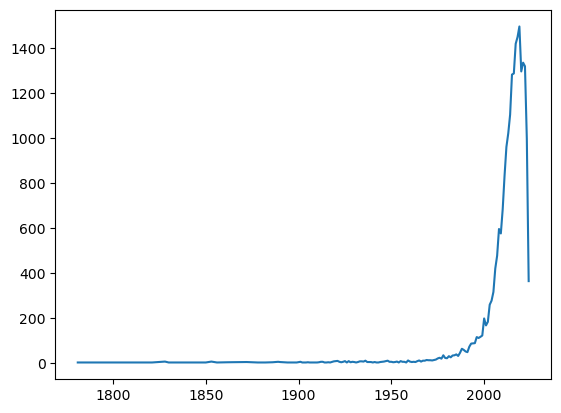

In [264]:
df_gb = df_frag.groupby('year').agg({'rating_value': 'median', 'rating_count':'sum', 'perfume':'count'})
plt.plot(df_gb.index, df_gb['perfume'])
plt.show()

In [265]:
df_gb = df_frag[(df_frag['year'] > 1975) & (df_frag['year'] < 2024)].groupby('year').agg({'rating_value': 'median', 'rating_count':'sum', 'perfume':'count'})

А теперь посмотрим на медианный рейтинг, начиная с 1975 года (примерно когда начало возрастать количество выпущенных ароматов)

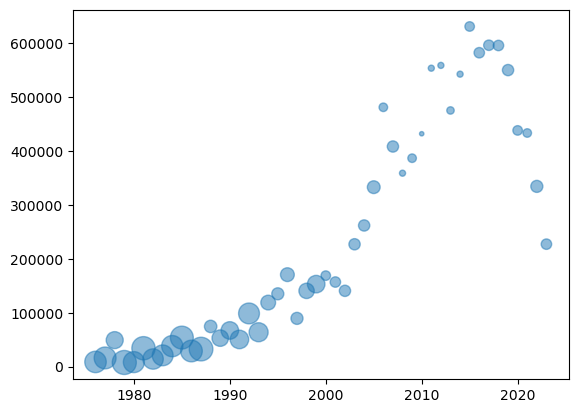

In [266]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(10, 300))

plt.scatter(df_gb.index, df_gb['rating_count'], s = scaler.fit_transform(df_gb[['rating_value']]).reshape(-1, 1),
            alpha=0.5)
plt.show()

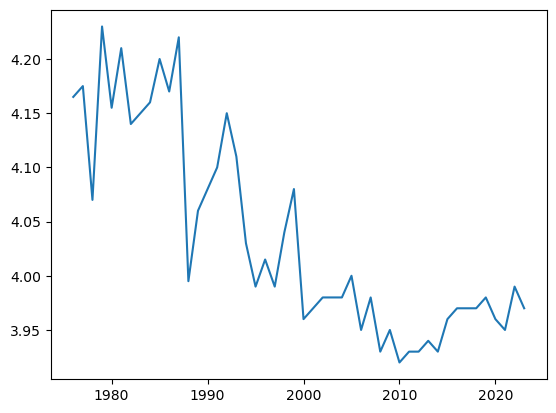

In [267]:
plt.plot(df_gb.index, df_gb['rating_value'])
plt.show()

Безусловно, хочется сказать, что "раньше было лучше", но, разумеется, это было бы, во-первых, упрощением, во-вторых, попросту неверно с учётом того, что фрагрантика появилась только в 2009. Плохие ароматы из прошлого перестали выпускаться или забылись, плюс с распространением нишевой парфюмерии выросло число специфических ароматов, не предназначенных для того, чтобы нравиться всем. 

Объединим данные

In [268]:
df_votes = df_votes.merge(df_frag, on = 'url_eng')
df_votes.head()

,text,url,user,url_eng,rating,perfume,brand,country,gender,rating_value,...,year,top,middle,base,perfumer1,mainaccord1,mainaccord2,mainaccord3,mainaccord4,mainaccord5
0,В версии туалетной воды понравился гораздо бол...,https://www.fragrantica.ru/perfume/Acqua-di-Pa...,Yuliya Vladi,https://www.fragrantica.com/perfume/acqua-di-p...,3,acqua-nobile-iris,acqua-di-parma,Italy,women,4.09,...,2013,"citron, grapefruit, mandarin orange","iris, orange blossom, neroli, violet leaves","musk, vanilla",unknown,citrus,white floral,iris,powdery,empty
1,Очень привлекательный весенне-летний аромат. К...,https://www.fragrantica.ru/perfume/Acqua-di-Pa...,Odessitka11,https://www.fragrantica.com/perfume/acqua-di-p...,3,acqua-nobile-iris,acqua-di-parma,Italy,women,4.09,...,2013,"citron, grapefruit, mandarin orange","iris, orange blossom, neroli, violet leaves","musk, vanilla",unknown,citrus,white floral,iris,powdery,empty
2,"Ирис+одеколонная нотка,+красиво( так чувствую)...",https://www.fragrantica.ru/perfume/Acqua-di-Pa...,Ринджик,https://www.fragrantica.com/perfume/acqua-di-p...,4,acqua-nobile-iris,acqua-di-parma,Italy,women,4.09,...,2013,"citron, grapefruit, mandarin orange","iris, orange blossom, neroli, violet leaves","musk, vanilla",unknown,citrus,white floral,iris,powdery,empty
3,Разбавленная 1:10 версия оригинального аромата...,https://www.fragrantica.ru/perfume/Acqua-di-Pa...,Batinka,https://www.fragrantica.com/perfume/acqua-di-p...,3,acqua-nobile-iris,acqua-di-parma,Italy,women,4.09,...,2013,"citron, grapefruit, mandarin orange","iris, orange blossom, neroli, violet leaves","musk, vanilla",unknown,citrus,white floral,iris,powdery,empty
4,Цветовое решение в оформлении флакона и упаков...,https://www.fragrantica.ru/perfume/Acqua-di-Pa...,сероглазка,https://www.fragrantica.com/perfume/acqua-di-p...,3,acqua-nobile-magnolia,acqua-di-parma,Italy,women,4.05,...,2013,"citron, lemon, neroli, bergamot, mandarin orange","magnolia, lily-of-the-valley, freesia, jasmine...","vanilla, musk",unknown,citrus,floral,white floral,fresh,empty


Для модели не принципиально уметь предсказывать конкретную оценку, поэтому таргет делаем бинарным: рекомендовать или нет. Отрицательное и нейтральное (0-2) не рекомендуем, положительное (3-4) рекомендуем.

In [270]:
def to_bin(x):
    if x < 3:
        return 0
    else:
        return 1

df_votes['target'] = df_votes['rating'].apply(to_bin)


In [ ]:
Перейдём к бейзлайну 

In [273]:
import rectools
from implicit.nearest_neighbours import TFIDFRecommender
from rectools import Columns
from rectools.dataset import Dataset
from rectools.models import ImplicitItemKNNWrapperModel

In [274]:
users = df_votes['user'].unique()
user_dict = {}

for i in range(len(users)):
    user_dict[users[i]] = i
    
urls = df_votes['url_eng'].unique()
url_dict = {}

for i in range(len(urls)):
    url_dict[urls[i]] = i

In [277]:
df_base = df_votes[['user', 'url_eng', 'target']].copy()

In [278]:
df_base['item_id'] = df_base['url_eng'].apply(lambda x: url_dict[x])
df_base['user_id'] = df_base['user'].apply(lambda x: user_dict[x])

In [280]:
df_base['target'].value_counts()

1    75833
0    25818
Name: target, dtype: int64

In [285]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_base, test_size=0.2)

In [287]:
from rectools import Columns
from rectools.dataset import Dataset

df = train.rename(columns={
    "user_id": Columns.User,     
    "item_id": Columns.Item,     
    "target": Columns.Weight     
})

df[Columns.Datetime] = pd.Timestamp.now()


dataset = Dataset.construct(df) 

In [289]:
from rectools.models import ImplicitItemKNNWrapperModel, PopularModel


model = PopularModel()
model.fit(dataset)

recos = model.recommend(
    users=df[Columns.User].unique(),
    dataset=dataset,
    k=10,
    filter_viewed=False,
)

In [290]:
df_test = test.rename(columns={
    "user_id": Columns.User,     
    "item_id": Columns.Item,     
    "target": Columns.Weight     
})

df_test[Columns.Datetime] = pd.Timestamp.now()


dataset = Dataset.construct(df_test) 

In [292]:
recos = model.recommend(
    users=df_test[Columns.User].unique(),
    dataset=dataset,
    k=10,
    filter_viewed=False,
)

In [313]:
from rectools.metrics import Precision, Recall, MAP, NDCG

ndcg = NDCG(k=10, log_base=3)

print("NDCG: ", ndcg.calc(reco=recos, interactions=df_test))
recall = Recall(k=10)

print("Recall: ", recall.calc(reco=recos, interactions=df_test))

NDCG:  0.0010446652992736
Recall:  0.004165666788484669
